In [4]:
import pde
from pde import FieldCollection, PDEBase, UnitGrid
import numpy as np
from PhysicalConstants2D import *
print("")

In [5]:
init_c_N_total = A_N*math.pi*math.pow(r,2)/(A_R_N * math.pow(r,2))
init_c_R_total = A_R*math.pi*math.pow(r,2)/(A_R_N * math.pow(r,2))
print(init_c_N_total)
print(init_c_R_total)

3.048874499257105
0.09271815433268715


In [6]:
#2d grid:

grid_radius = 30 # grid_width, grid_height = 2*grid_radius
cells_per_unit = 2
cells_width = cells_per_unit*2*grid_radius
cells_height = cells_per_unit*2*grid_radius

grid = pde.CartesianGrid([[-grid_radius,grid_radius],[-grid_radius,grid_radius]], [cells_width,cells_height])

### Initial field for each concentration

# We use circles for the release site and the reaction site. The circles have the same radius and center.
release_radius = 14.7
react_radius = 14.7

#grid.plot()

In [7]:
# Create initial fields for each concentration. We assign the correct values to the points inside the release/react circles

# c_N:
field_c_N = pde.ScalarField.from_expression(grid, f"x**2 + y**2 <= {release_radius}**2", label="c_N_field")
points_in_release_circle = np.unique(field_c_N.data, return_counts=True)[1][1]
init_c_N_per_grid = init_c_N_total/points_in_release_circle
print("initial c_N per cell: ", init_c_N_per_grid)
field_c_N.data = field_c_N.data * init_c_N_per_grid

# c_R:
field_c_R = pde.ScalarField.from_expression(grid, f"x**2 + y**2 <= {react_radius}**2", label="c_R_field")
points_in_react_circle = np.unique(field_c_R.data, return_counts=True)[1][1]
init_c_R_per_grid = init_c_R_total/points_in_react_circle
print("initial c_R per cell: ", init_c_R_per_grid)
field_c_R.data = field_c_R.data * init_c_R_per_grid

# c_RN:
field_c_RN = pde.ScalarField(grid, label="c_RN_field")

# c_T:
field_c_T = pde.ScalarField.from_expression(grid, f"x**2 + y**2 > {max(release_radius, react_radius)}**2", label="c_T_field")
transporter_consentration = init_c_R_per_grid
field_c_T.data = field_c_T.data * transporter_consentration

# c_TN:
field_c_TN = pde.ScalarField(grid, label="c_TN_field")

# c_N_inact:
field_c_N_inact = pde.ScalarField(grid, label="c_N_inact_field")


print("")
# print(np.unique(field_c_N.data, return_counts=True))
# print(np.unique(field_c_R.data, return_counts=True))
# print(np.unique(field_c_RN.data, return_counts=True))
# print(np.unique(field_c_T.data, return_counts=True))
# print(np.unique(field_c_TN.data, return_counts=True))
# print(np.unique(field_c_N_inact.data, return_counts=True))


# We collect all the fields
state = FieldCollection([field_c_N, field_c_R, field_c_RN, field_c_T, field_c_TN, field_c_N_inact])

# We define all the dimensionless constants
epsilon_1 = 1 #3.6309e-5
eta_1 = 0.5 #0.80666
epsilon_2 = 1
eta_2 = 0.5
eta_3 = 0.5

initial c_N per cell:  0.0011258768461067596
initial c_R per cell:  3.423860942861416e-05



In [8]:
eq = pde.PDE({
    "c_N" :      f"laplace(c_N) -{epsilon_1}*c_R*c_N-{epsilon_2}*c_T*c_N +{eta_1}*c_RN+{eta_2}*c_TN",
    "c_R" :      f"-{epsilon_1}*c_R*c_N +{eta_1}*c_RN",
    "c_RN" :     f"{epsilon_1}*c_R*c_N -{eta_1}*c_RN",
    "c_T":       f"-{epsilon_2}*c_T*c_N+{eta_2}*c_TN+{eta_3}*c_TN",
    "c_TN":      f"{epsilon_2}*c_T*c_N-{eta_2}*c_TN-{eta_3}*c_TN",
    "c_N_inact": f"{eta_3}*c_TN",
    })

storage = pde.MemoryStorage()

In [9]:
result = eq.solve(state, t_range=3, dt=1e-6, tracker=["progress", storage.tracker(1e-3)])

100%|██████████| 3.0/3.0 [26:35<00:00, 531.96s/it]         


100%|██████████| 3001/3001 [20:21<00:00,  2.46it/s]


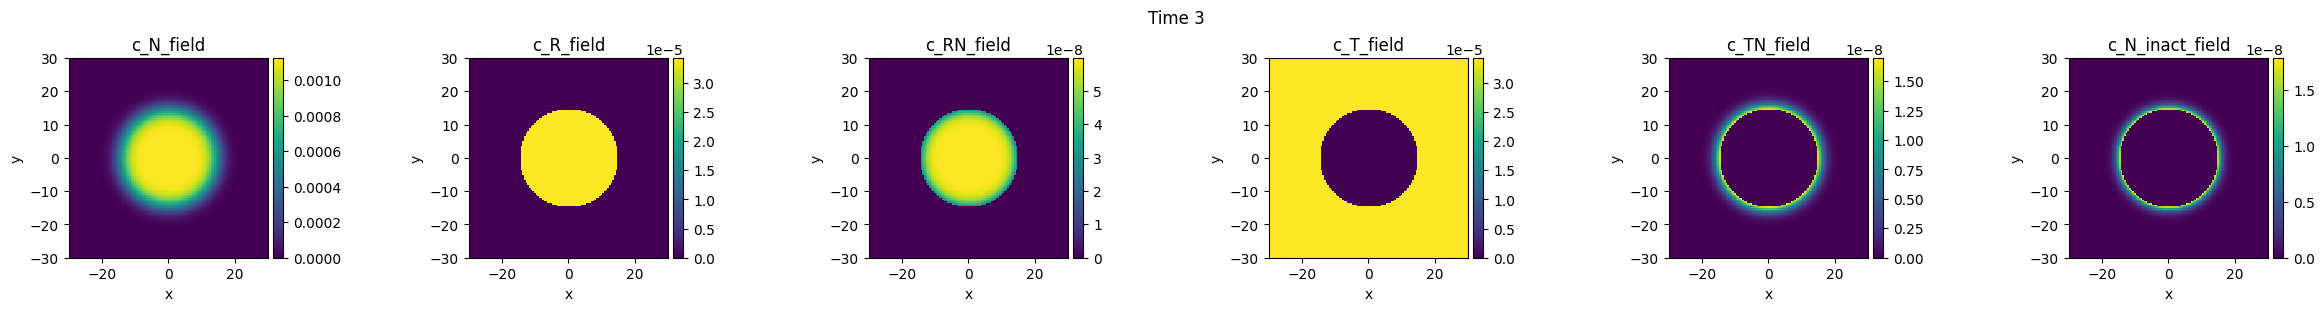

In [10]:
pde.movie(storage, filename="./Animations/transportation_2.mp4")